# Experiments and analysis for 1st paper

For each output variable [TPHYSTND_NORAD, PHQ, QRL, QRS] the $R^2$ is computed for each level $z$ and then averaged:

$$ R^2_z = 1 - (SSE_z / TVAR_z) $$

where SSE, the sum of squared errors is computed from the predicted values $y$ and the corresponding true values $\hat{y}$:

$$ SSE_z = \frac{1}{nt \times nx \times ny}\sum_{nt}\sum_{nx}\sum_{ny} (y_{t, x, y} - \hat{y}_{t, x, y})^2$$

and the TVAR, the true variance is:

$$ TVAR_Z = \frac{1}{nt \times nx \times ny}\sum_{nt}\sum_{nx}\sum_{ny} (\hat{y}_{t, x, y} - \bar{\hat{y}})^2 $$

with $\bar{\hat{y}}$ being the true mean over $t, x, y$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cbrain.imports import *
from cbrain.model_diagnostics import *
from cbrain.utils import *
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from IPython.display import SVG, HTML
from string import ascii_lowercase
%matplotlib inline
limit_mem()

/export/home/srasp/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
MODEL_DIR = '/export/home/srasp/repositories/CBRAIN-Keras-Diagnostics/saved_models/'
DATA_DIR = '/scratch/srasp/preprocessed_data/'

In [4]:
def get_d(m, trn='sample1', val='sample1'):
    d = ModelDiagnostics(
        MODEL_DIR+f'{m}.h5',
        fpath=f'{DATA_DIR}paper_nonorm_valid_{val}_features.nc',
        tpath=f'{DATA_DIR}paper_nonorm_valid_{val}_targets.nc',
        npath=f'{DATA_DIR}paper_nonorm_train_{trn}_norm.nc',
        norms=('feature_means', 'feature_stds', None, 'target_conv')
    )
    return d

## Network architecture sensitivity test

- Training: 60 days. Days 5-9 from each month of year 1.
- Validation: 60 days. Days 5-9 from each month of year 2.

The goal of this sensitivity test is to assess the number of parameters and the arrangement (shallow vs. wide).

- Number of input variables: 123
- Number of output variables: 120

All networks are trained with LeakyReLU activation functions $z(a) = \max(0.3x, x)$.

The loss function is the mean squared error.

These networks were trained with a batch size of 1024 (see sensitivity below). The starting learning rate was 1e-3. Every 5 epochs the learning rate was divided by 5. We trained for 20 epochs.

For input normalization, we are subtracting each variable by its mean and then divide it by its standard deviation to get mean zero, standard deviation one. 

For the outputs we are multiplying the heating tendencies (TPHYSTND_NORAD, QRL, QRS) by $C_p = 1 \times 10^3$ and the moistening tendency PHQ by $L_v = 2.5 \times 10^6$, so that they are all in energy units W/m^2. 


In [5]:
def npar(l):
    l = [l] if not type(l) == list else l
    l = [123] + l + [120]
    return sum([l[i] * l[i+1] + l[i+1] for i in range(len(l)-1)])

In [6]:
l_shallow = [128, 512, 2048, 8192]
l_medium = [[l]*2 for l in [90, 256, 600, 1300]]
l_deep = [[l]*8 for l in [50, 115, 256, 512]]

**Architectures**

| Approx. # Param | 30k | 125k | 500k | 2M |
| --- | --- | --- | --- | --- |
| Shallow | 128 | 512 | 2048 | 8192 |
| Medium | 90 x 2 | 256 x 2 | 600 x 2 | 1300 x 2 |
| Deep | 50 x 8 | 115 x 8 | 256 x 8 | 512 x 8 |

*Note that powers of 2 are usually chosen for GPU speed. For the sensitivity test we disregarded this sometimes.*

In [7]:
mlist_shallow = ['P001_128_sample1', 'P002_512_sample1', 'P003_2048_sample1', 'P004_8192_sample1']
mlist_medium = ['P005_90x2_sample1', 'P006_256x2_sample1', 'P007_600x2_sample1', 'P008_1300x2_sample1']
mlist_deep = ['P009_50x8_sample1', 'P010_115x8_sample1', 'P011_256x8_sample1', 'P012_512x8_sample1']

In [8]:
npars_shallow = [npar(l) for l in l_shallow]
npars_medium = [npar(l) for l in l_medium]
npars_deep = [npar(l) for l in l_deep]

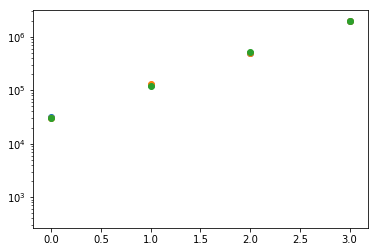

In [9]:
plt.scatter(range(4), npars_shallow, marker='o')
plt.scatter(range(4), npars_medium, marker='o')
plt.scatter(range(4), npars_deep, marker='o')
plt.gca().set_yscale('log')

In [10]:
dlist = list()
for mlist in [mlist_shallow, mlist_medium, mlist_deep]:
    tmp = []
    for m in mlist:
        d = get_d(m)
        if os.path.exists('./tmp/' + d.save_str): d.load_stats()
        else: d.compute_stats(); d.save_stats()
        tmp.append(d)
    dlist.append(tmp)

In [11]:
r2s = [[d.mean_stats(10)['hor_r2']['all'] for d in dd] for dd in dlist]

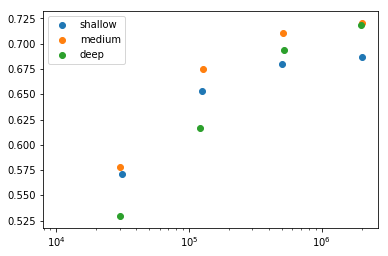

In [12]:
plt.scatter(npars_shallow, r2s[0], marker='o', label='shallow')
plt.scatter(npars_medium, r2s[1], marker='o', label='medium')
plt.scatter(npars_deep, r2s[2], marker='o', label='deep')
plt.gca().set_xscale('log'); plt.legend();

In [21]:
factors = np.array([C_P, L_V, C_P, C_P]); factors

array([1.0e+03, 2.5e+06, 1.0e+03, 1.0e+03])

In [42]:
mses = [
    [(d.mean_stats()['mse'][:4].values.astype('float') * factors**2).mean() for d in dd] 
    for dd in dlist]

In [103]:
def plot_arch_sens(ax, s=50):
    ax.scatter(npars_shallow, mses[0], marker='o', label='shallow',s=s)
    ax.scatter(npars_medium, mses[1], marker='x', label='medium',s=s)
    ax.scatter(npars_deep, mses[2], marker='^', label='deep',s=s)
    ax.set_xscale('log'); ax.legend();
    ax.set_ylim(np.min(mses)*0.98, np.max(mses)*1.02); ax.set_xlim(2e4, 3e6);
    ax.set_xlabel('Number of network parameters')
    ax.set_ylabel(r'MSE [W$^2$/m$^4$]')
    ax.set_title('a) Sensitivity to network architecture')
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    despine(ax)

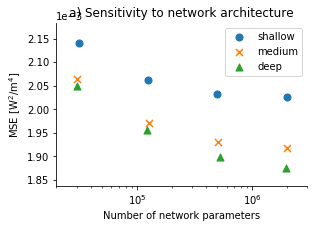

In [104]:
fig, ax = plt.subplots(figsize=(4.5, 3))
plot_arch_sens(ax)

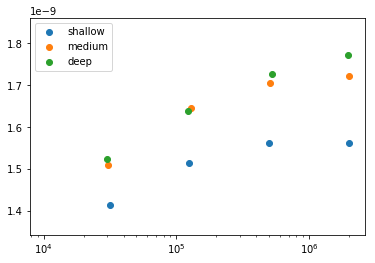

In [269]:
tmp = [[d.mean_stats(10)['pred_var']['TPHYSTND_NORAD'] for d in dd] for dd in dlist]
plt.scatter(npars_shallow, tmp[0], marker='o', label='shallow')
plt.scatter(npars_medium, tmp[1], marker='o', label='medium')
plt.scatter(npars_deep, tmp[2], marker='o', label='deep')
plt.gca().set_xscale('log'); plt.legend();
plt.ylim(np.min(tmp)*0.95, np.max(tmp)*1.05);

As we can see the architecture question is a little more subtle. Whether deep is better than medium depends on the variable in question and the metric used. 

There is however a clear statment for the number of parameters. More gives a better fit. For the subsequent analyses we will use the **deep, large network**. 

### Does it matter whether we validate with 60 days or a full year?

In [10]:
d_fullyear = get_d(mlist[1], val='fullyear')

In [108]:
#d_fullyear.compute_stats(); d_fullyear.save_stats()

100%|██████████| 17519/17519 [15:33<00:00, 18.76it/s]
/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:241: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])


In [11]:
d_fullyear.load_stats()

In [110]:
d_fullyear.mean_stats(10)

/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:275: RuntimeWarning: divide by zero encountered in true_divide
  lev_r2 = 1. - (np.mean(mse, axis=(0, 1)) / np.mean(true_var, axis=(0, 1)))


,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,r2_v2
TPHYSTND_NORAD,-3.03274e-07,1.35405e-09,1.10627e-05,1.1366e-05,1.80147e-09,3.22793e-09,1.52674e-09,2.937e-09,0.244694,0.547209
PHQ,2.24975e-10,1.74521e-15,1.3343e-09,1.10933e-09,7.24496e-16,2.48544e-15,6.68094e-16,2.43478e-15,-16.9303,0.515226
QRL,4.60526e-08,1.65383e-10,-1.73767e-05,-1.74227e-05,6.63799e-10,8.43212e-10,2.71015e-10,4.46311e-10,0.532651,0.649254
QRS,4.83492e-07,7.0164e-11,6.65222e-06,6.16872e-06,1.23627e-10,1.79297e-10,5.27433e-11,1.18599e-10,-inf,0.424489
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.534044


In [111]:
dlist[1].mean_stats(10)

/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:275: RuntimeWarning: divide by zero encountered in true_divide
  lev_r2 = 1. - (np.mean(mse, axis=(0, 1)) / np.mean(true_var, axis=(0, 1)))


,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,r2_v2
TPHYSTND_NORAD,-3.11576e-07,1.34097e-09,1.09873e-05,1.12988e-05,1.78108e-09,3.19913e-09,1.48801e-09,2.88997e-09,0.0900301,0.544513
PHQ,2.24497e-10,1.73858e-15,1.32396e-09,1.09946e-09,7.19093e-16,2.47601e-15,6.58004e-16,2.42112e-15,-25.5372,0.512341
QRL,3.90402e-08,1.62918e-10,-1.74028e-05,-1.74418e-05,6.59047e-10,8.35577e-10,2.5984e-10,4.32452e-10,0.480565,0.644567
QRS,4.328e-07,6.8975e-11,6.59336e-06,6.16056e-06,1.22272e-10,1.77773e-10,5.19385e-11,1.16738e-10,-inf,0.425857
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531820


There is harly any difference between the statistics computed for 60 days and for a full year. To speed up analysis we will use the 60 day version.

### Batch size sensitivity

In [48]:
bss = [128, 256, 512, 1024]

In [44]:
bs_list = ['P015_512x8_sample1_bs128', 'P014_512x8_sample1_bs256', 'P013_512x8_sample1_bs512',
           'P012_512x8_sample1']

In [45]:
bsd = []
for b in bs_list:
    d = get_d(b)
    if os.path.exists('./tmp/' + d.save_str): d.load_stats()
    else: d.compute_stats(); d.save_stats()
    bsd.append(d)

100%|██████████| 2868/2868 [03:21<00:00, 14.23it/s]
/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:240: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:246: RuntimeWarning: divide by zero encountered in true_divide
  self.stats['hor_r2'] = 1 - (self.stats['hor_mse'] / self.stats['hor_tvar'])
100%|██████████| 2868/2868 [03:14<00:00, 14.76it/s]
/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:240: RuntimeWarning: invalid value encountered in true_divide
  self.stats['r2'] = 1. - (self.stats['mse'] / self.stats['true_var'])
/data11/home/srasp/repositories/CBRAIN-Keras-Diagnostics/notebooks/presentation/cbrain/model_diagnostics.py:246: RuntimeWarning: invalid value encountered in true_d

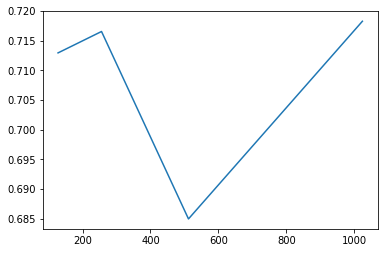

In [51]:
plt.plot(bss, [d.mean_stats(10)['hor_r2']['all'] for d in bsd]);

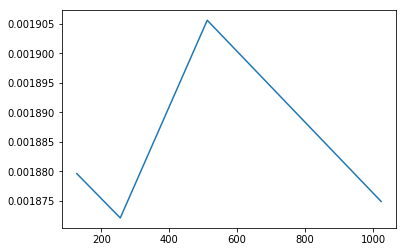

In [53]:
plt.plot(bss, [(d.mean_stats()['mse'][:4].values.astype('float') * factors**2).mean() for d in bsd] );

The results here are a little unintuitive. Part of it could be random scatter, but given our amount of data that seems unlikely. More likely is a non-optimal tuning of the learning rate schedule with batch size. In fact a look at the TensorBoard graph suggests exactly that. At larger learning rates the loos shoots off to very large values. 

However, the difference between the batch sizes is much smaller than the difference between diferent architectures, which is why we will keep using bs=1024 noting that large batch sizes speed up training.

## Training amount sensitivity tests

Using selected network from above.

- Training with continuous periods:
    - 1 week
    - 1 month
    - 3 month
    - 6 month
    - 9 month
    - 12 month
- Validation
    - Test: 60 days vs full 2nd year

In [106]:
# Create placeholder
def plot_time_sens(ax, s=50):
    days = np.array([10, 30, 60, 90, 180, 270, 360])
    months = days/30.
    score = np.log(months)
    ax.scatter(months, score, marker='o', s=s)
    #ax.set_ylim(np.min(score)*0.95, np.max(score)*1.05); 
    ax.set_xlim(0, 12.5);
    ax.set_xlabel('Months of training data')
    ax.set_ylabel(r'MSE [W$^2$/m$^4$]')
    ax.set_title('b) Sensitivity to amount of training data')
    despine(ax)

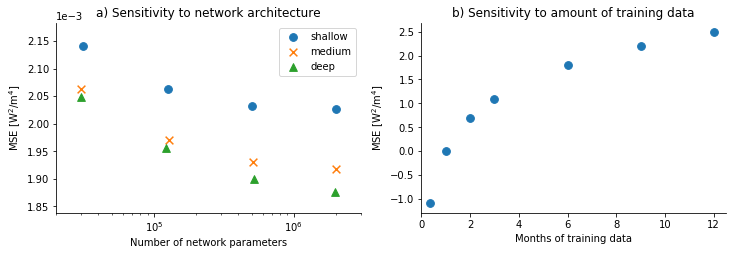

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(12, 3.5))
plot_arch_sens(axes[0], 60)
plot_time_sens(axes[1], 60)

## Figures

### Setup

In [110]:
# Load model for figures
d = get_d('P012_512x8_sample1', val='sample1')

In [111]:
d.load_stats()

In [112]:
# Load one xarray file to get coordinates
ds = xr.open_dataset('/scratch/srasp/Aquaplanet_enhance05/AndKua_aqua_SPCAM3.0_enhance05.cam2.h1.0000-01-01-00000.nc',
                     decode_times=False)

In [113]:
lat, lon, lev = ds.lat.values, ds.lon.values, ds.lev.values

In [144]:
latrange = lat.max()-lat.min(); lonrange = lon.max()-lon.min(); levrange = lev.max()-lev.min()
latrange, lonrange, levrange

(175.72759767846526, 357.1875, 988.912629429251)

In [145]:
# Make sure lat-lon and lev-lat plots have same sizes
# Width / height
tmp = lonrange / latrange; tmp

2.0326204006587405

In [146]:
asp = (latrange/tmp)/levrange; asp

0.0874230126630051

In [115]:
vars = ['TPHYSTND_NORAD', 'PHQ', 'QRL', 'QRS']

In [141]:
lims = {
    'TPHYSTND_NORAD': [-7e-4, 7e-4],
    'PHQ': [-4e-7, 4e-7],
    'QRL': [-1.5e-4, 1.5e-4],
    'QRS': [-1.5e-4, 1.5e-4],
}

In [117]:
name = {
    'TPHYSTND_NORAD': 'Convective heating rate',
    'PHQ': 'Convective moistening rate',
    'QRL': 'Longwave heating rate',
    'QRS': 'Shortwave heating rate'
}

In [118]:
unit = {
    'TPHYSTND_NORAD': '[K/s]',
    'PHQ': '[kg/kg/s]',
    'QRL': '[K/s]',
    'QRS': '[K/s]'
}

In [119]:
def plot_panels(axes, p, t, var, cmap='bwr', xlabel=True, title='var', labels=None,
                yz=False):
    if yz:
        x, y = lat, lev
        p, t = p.T, t.T
    else: 
        x, y = lon, lat
    I1, I2 = [ax.pcolormesh(x, y, a, vmin=lims[var][0], vmax=lims[var][1], cmap=cmap) 
              for ax, a in zip(axes.flat, [p, t])]
    if not yz: [ax.set_aspect('equal') for ax in axes.flat]
    if yz: [ax.invert_yaxis() for ax in axes.flat]
    if xlabel: 
        [ax.set_xlabel('Latitude' if yz else 'Longitude') for ax in axes.flat]
        if not yz: [ax.set_xticks(range(0, 361, 60)) for ax in axes.flat]
    else: [ax.set_xticks([]) for ax in axes.flat]
    axes[0].set_ylabel('Pressure [hPa]' if yz else 'Latitude'); axes[1].set_yticks([])
    if title == 'var':
        pos = [ax.get_position().get_points() for ax in axes.flat]
        pos = pos[0][1][1]
        plt.text(0.45, pos-0.01, name[var], transform=plt.gcf().transFigure,
                 horizontalalignment='center', fontsize=12)
    else:
        axes[0].set_title('CBRAIN Predictions'); axes[1].set_title('SP-CAM Truth')
    if labels is not None:
        [ax.text(0.01, 0.90, l, transform=ax.transAxes, fontsize=12)
         for ax, l in zip(axes, labels)]
    cb = fig.colorbar(I1, ax=axes.ravel().tolist(), shrink=0.75, pad=0.01, extend='both')
    cb.set_label(unit[var])
    cb.formatter.set_powerlimits((-1, 1))
    cb.ax.yaxis.set_offset_position('left') 
    cb.update_ticks()
    return I1, I2

In [120]:
def xy_wrap(axes, itime, ilev, var, **kwargs):
    p, t = d.get_pt(itime=itime, var=var)
    plot_panels(axes, p[:, :, ilev], t[:, :, ilev], var, **kwargs)

In [121]:
def yz_wrap(axes, itime, ilon, var, **kwargs):
    p, t = d.get_pt(itime=itime, var=var)
    plot_panels(axes, p[:, ilon, :], t[:, ilon, :], var, **kwargs)

In [122]:
def animate_lat_lon(ilev, var, max_time=5, interval=200):
    p, t = d.get_pt(itime=0, var=var)
    fig, axes = plt.subplots(1, 2, figsize=(15, 4))
    plt.subplots_adjust(wspace=0.03)
    I1, I2 = plot_panels(axes, p[:, :, ilev], t[:, :, ilev], var, title='other')
    fig.suptitle('Time = 0')
    def update(i):
        p, t = d.get_pt(itime=i, var=var)
        fig.suptitle(f'Time = {i}')
        I1.set_array(p[:, :, ilev].ravel()); I2.set_array(t[:, :, ilev].ravel())
        return I1, I2, 
    plt.close(fig)
    return FuncAnimation(fig, update, frames=np.arange(1, max_time), interval=interval, blit=True)

In [123]:
def despine(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

### Snapshots/animations

#### Lat-lon slices

In [138]:
labels = []
for i in range(4):
    labels.append([f'{ascii_lowercase[i*2]}) CBRAIN', f'{ascii_lowercase[i*2+1]}) SP-CAM'])

In [139]:
lev[20]

691.3894303143024

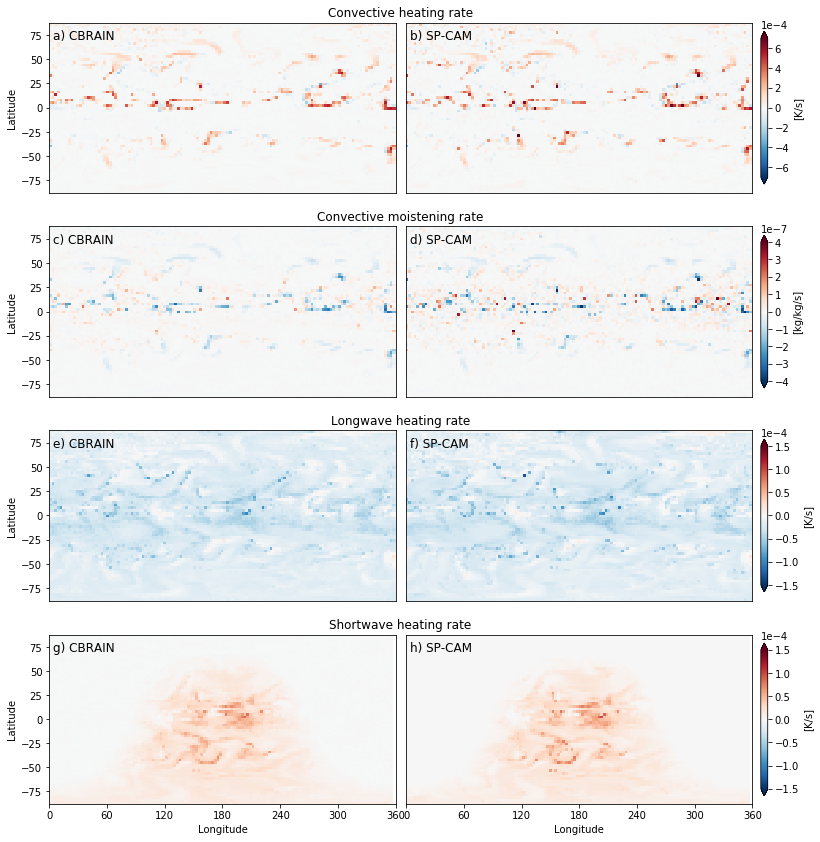

In [142]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.03, hspace=0.)
for i, v in enumerate(vars): 
    xy_wrap(axes[i], 0, 20, v, xlabel = True if i == 3 else False, labels=labels[i], cmap='RdBu_r')

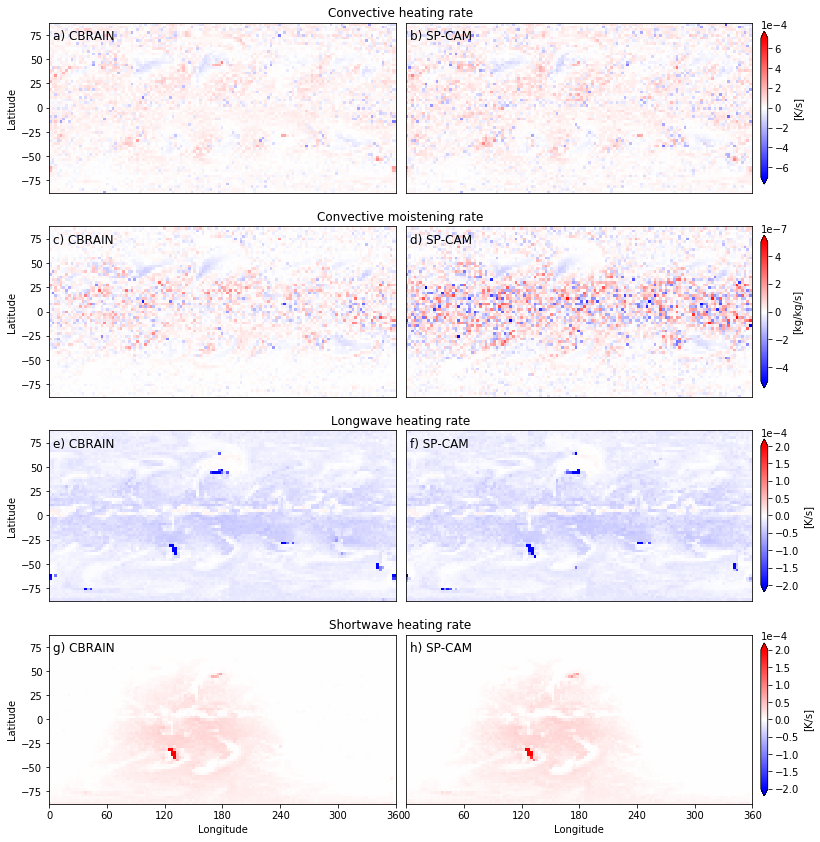

In [152]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.03, hspace=0.)
for i, v in enumerate(vars): 
    xy_wrap(axes[i], 100, -1, v, xlabel = True if i == 3 else False, labels=labels[i])

In [135]:
anim = animate_lat_lon(20, 'TPHYSTND_NORAD')

In [136]:
HTML(anim.to_html5_video())

#### Lev-Lat slices

In [135]:
lon[64]

180.0

In [150]:
lims = {
    'TPHYSTND_NORAD': [-4e-4, 4e-4],
    'PHQ': [-4e-7, 4e-7],
    'QRL': [-1.5e-4, 1.5e-4],
    'QRS': [-1.5e-4, 1.5e-4],
}

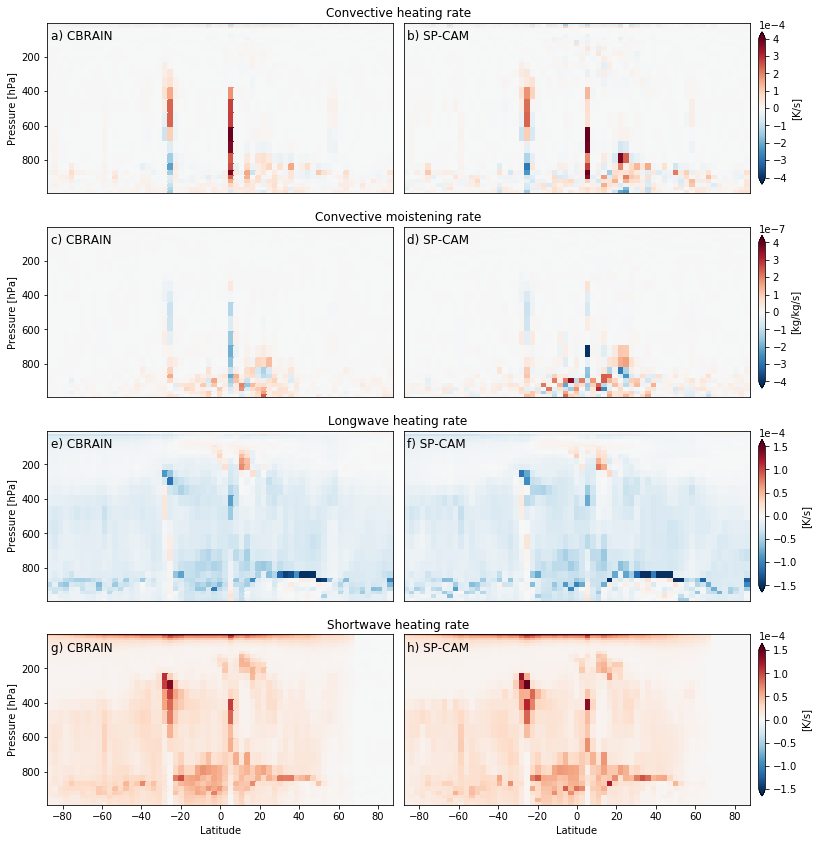

In [151]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.03, hspace=0.)
for i, v in enumerate(vars): 
    yz_wrap(axes[i], 0, 64, v, xlabel = True if i == 3 else False, labels=labels[i], yz=True,
            cmap='RdBu_r')
[ax.set_aspect(asp) for ax in axes.flat];

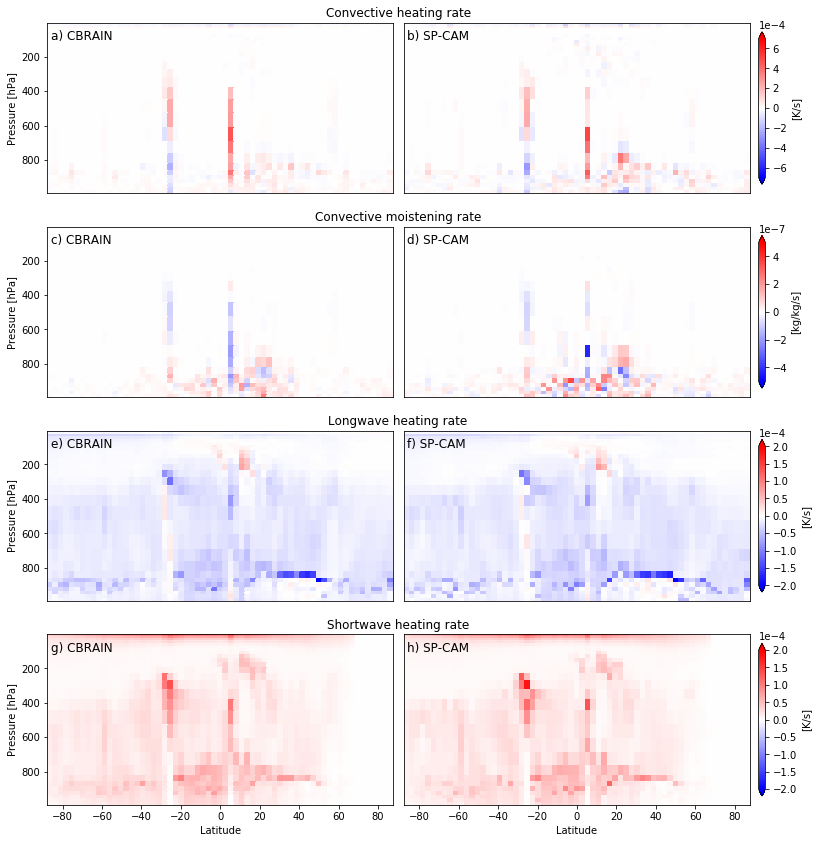

In [61]:
fig, axes = plt.subplots(4, 2, figsize=(15, 15))
plt.subplots_adjust(wspace=0.03, hspace=0.)
for i, v in enumerate(vars): 
    yz_wrap(axes[i], 0, 64, v, xlabel = True if i == 3 else False, labels=labels[i], yz=True,
            cmap='bwr')
[ax.set_aspect(asp) for ax in axes.flat];

### Statistics

lat-lev, averaged over lon: MSE, TVAR, PVAR, R2, bias

lev, averaged over lat, lon: R2

In [23]:
d.load_stats()

In [24]:
d.stats.keys()

dict_keys(['bias', 'mse', 'pred_mean', 'true_mean', 'pred_sqmean', 'true_sqmean', 'pred_var', 'true_var', 'r2', 'hor_tsqmean', 'hor_tmean', 'hor_mse', 'hor_tvar', 'hor_r2'])

In [25]:
labels2 = []
for i in range(4):
    labels2.append([f'{ascii_lowercase[i*2]}) Bias', f'{ascii_lowercase[i*2+1]}) RMSE'])

In [109]:
np.atleast_2d(np.ones(2)).shape

(1, 2)

In [152]:
from matplotlib import patches, patheffects

In [153]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='white'), patheffects.Normal()])

In [212]:
def plot_4stats(d, stat, title='', vmult=1, only_pos=False, func=None, mylims=None, rows=2,
                letter_offset=0, masks=None, extend='both', **kwargs):
    fig, axes = plt.subplots(rows, 2, figsize=(15, 3.5 * rows))
    axes = np.atleast_2d(axes)
    plt.subplots_adjust(wspace=0.0, hspace=0.)
    for i, (ax, v) in enumerate(zip(axes.flat, vars)):
        if func:
            a = func(d, v)
        else:
            a = d.stats[stat][:,:,d.tvars.index(v)].mean(1)
        if mylims is None: 
            vmin = 0 if only_pos else lims[v][0]*vmult
            vmax = lims[v][1]*vmult
        else:
            vmin = mylims[0]; vmax = mylims[1]
        if masks is not None: a[masks[i]] = np.nan
        I = ax.pcolormesh(lat, lev, a.T, vmin=vmin, vmax=vmax, **kwargs)
        txt = ax.text(0.01, 0.90, f'{ascii_lowercase[i+letter_offset]}) {name[v]}', 
                      transform=ax.transAxes, fontsize=12)
        draw_outline(txt, 2)
        cb = fig.colorbar(I, ax=ax, orientation='vertical', shrink=0.8, pad=0.02, 
                          extend=extend)
        cb.set_label(unit[v])
        cb.formatter.set_powerlimits((-1, 1))
        cb.ax.yaxis.set_offset_position('left') 
        cb.update_ticks()
        
    [ax.set_ylabel('Pressure [hPa]') for ax in axes[:,0].flat]
    [ax.set_yticks([]) for ax in axes[:,1].flat]
    [ax.invert_yaxis() for ax in axes.flat]
    if rows > 1: [ax.set_xticks([]) for ax in axes[0].flat]
    [ax.set_xlabel('Latitude') for ax in axes[-1].flat]
    [ax.set_aspect(asp) for ax in axes.flat];
    fig.suptitle(title, fontsize=14, x=0.47,y=0.93)

In [199]:
masks = [(d.stats['true_var'][:,:,d.tvars.index(v)].mean(1) < 
         d.stats['true_var'][:,:,d.tvars.index(v)].mean() * 0.0005) for v in vars]

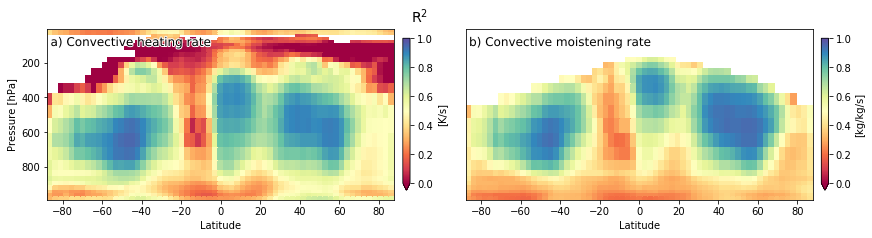

In [210]:
plot_4stats(d, 'r2', r'R$^2$', cmap='Spectral', mylims=[0, 1], rows=1, only_pos=True,
            masks=masks, extend='min')

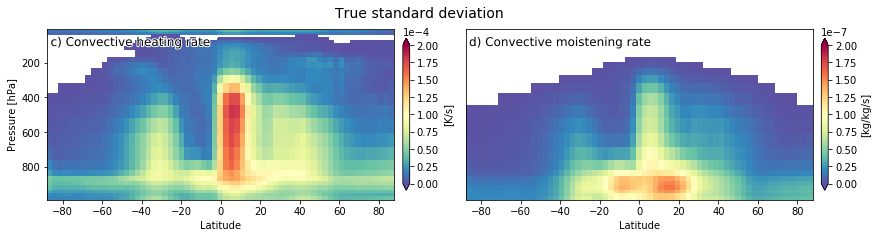

In [222]:
plot_4stats(d, '', 'True standard deviation', vmult=0.5, cmap='Spectral_r', only_pos=True,
            func=lambda d, v: np.sqrt(d.stats['true_var'][:,:,d.tvars.index(v)].mean(1)),
            masks=masks, rows=1, letter_offset=2)

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


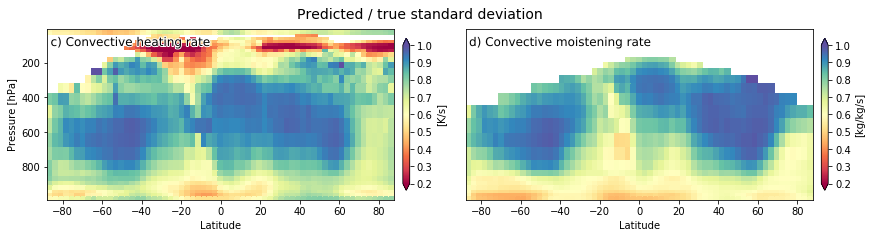

In [208]:
plot_4stats(d, '', 'Predicted / true standard deviation', vmult=0.3, cmap='Spectral', mylims=[0.2, 1],
            func=lambda d, v: (np.sqrt(d.stats['pred_var'][:,:,d.tvars.index(v)].mean(1)) /
                               np.sqrt(d.stats['true_var'][:,:,d.tvars.index(v)].mean(1))),
            rows=1, letter_offset=2, masks=masks
           )

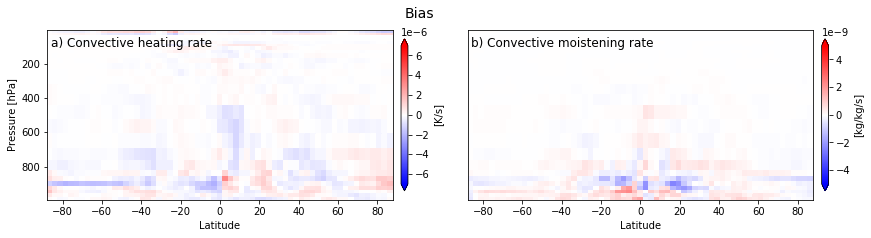

In [114]:
plot_4stats(d, 'bias', 'Bias', vmult=0.01, cmap='bwr', rows=1)

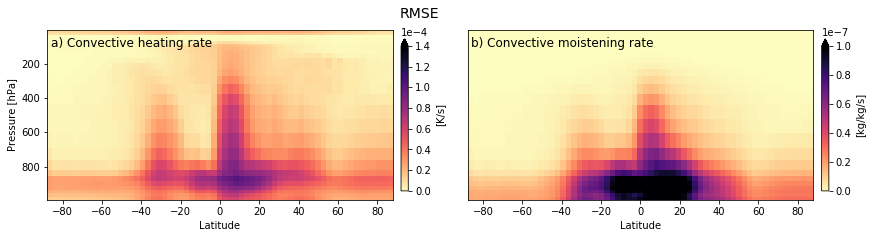

In [120]:
plot_4stats(d, '', 'RMSE', vmult=0.2, cmap='magma_r', only_pos=True, rows=1,
            func=lambda d, v: np.sqrt(d.stats['mse'][:,:,d.tvars.index(v)].mean(1)),
            letter_offset=0)

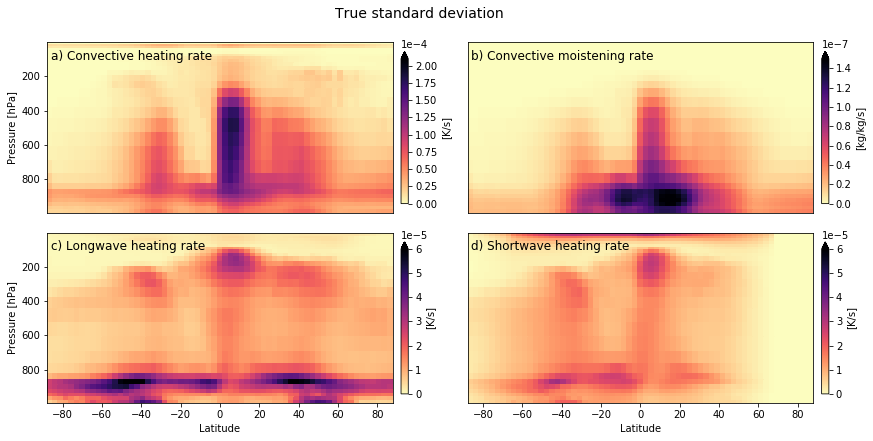

In [33]:
plot_4stats('', 'True standard deviation', vmult=0.3, cmap='magma_r', only_pos=True,
            func=lambda d, v: np.sqrt(d.stats['true_var'][:,:,d.tvars.index(v)].mean(1)))

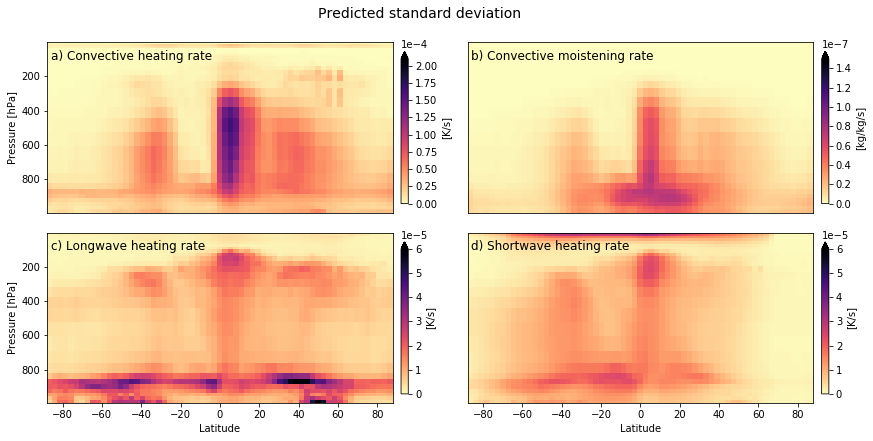

In [188]:
plot_4stats('', 'Predicted standard deviation', vmult=0.3, cmap='magma_r', only_pos=True,
            func=lambda d, v: np.sqrt(d.stats['pred_var'][:,:,d.tvars.index(v)].mean(1)))

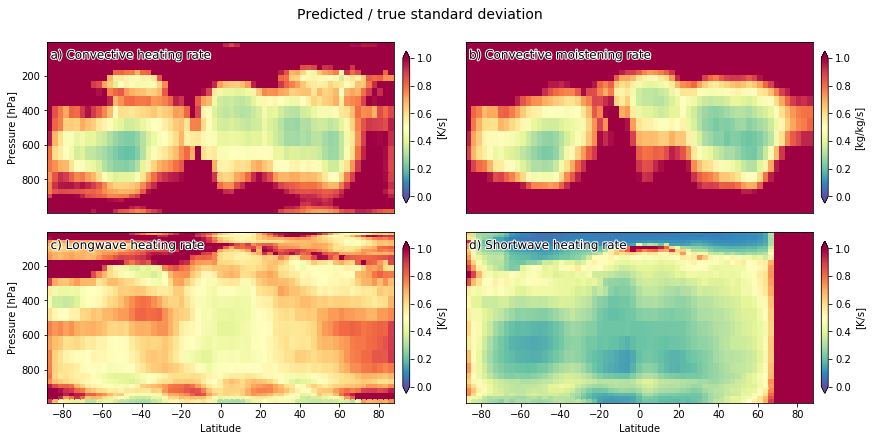

In [215]:
plot_4stats(d, '', 'Predicted / true standard deviation', vmult=0.3, cmap='Spectral_r', mylims=[0, 1],
            func=lambda d, v: (np.sqrt(d.stats['mse'][:,:,d.tvars.index(v)].mean(1)) /
                               np.sqrt(d.stats['pred_var'][:,:,d.tvars.index(v)].mean(1)))
           )

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


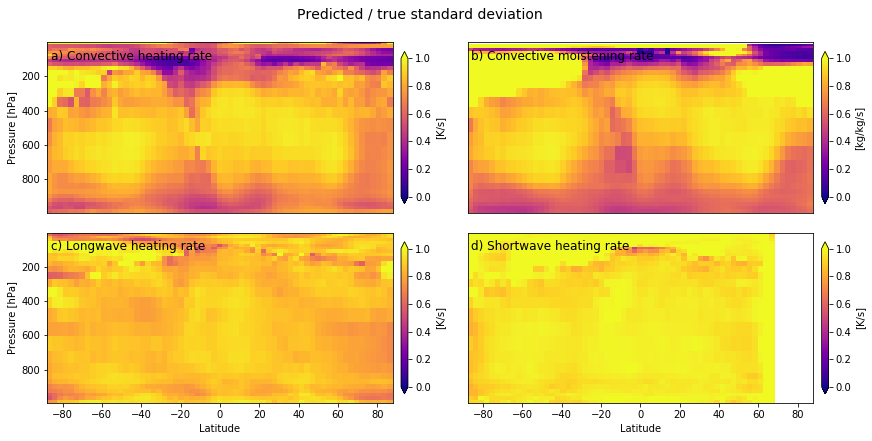

In [72]:
plot_4stats(d, '', 'Predicted / true standard deviation', vmult=0.3, cmap='plasma', mylims=[0, 1],
            func=lambda d, v: (np.sqrt(d.stats['pred_var'][:,:,d.tvars.index(v)].mean(1)) /
                               np.sqrt(d.stats['true_var'][:,:,d.tvars.index(v)].mean(1)))
           )

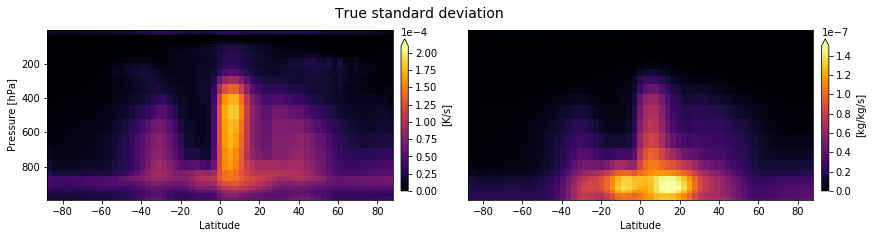

In [149]:
plot_4stats(d, '', 'True standard deviation', vmult=0.3, cmap='inferno', only_pos=True, rows=1,
            func=lambda d, v: np.sqrt(d.stats['true_var'][:,:,d.tvars.index(v)].mean(1)))

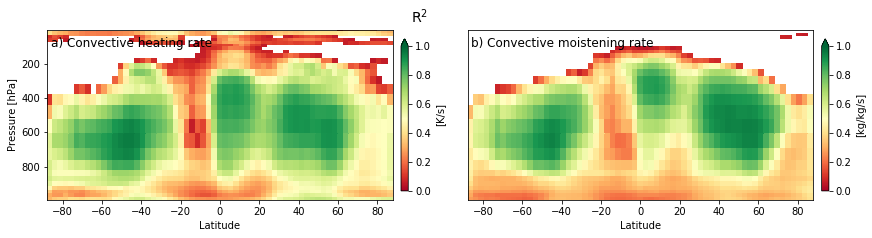

In [142]:
plot_4stats(d, 'r2', r'R$^2$', cmap='RdYlGn', mylims=[0, 1], rows=1, only_pos=True,
            mask=lambda d, v: d.stats['r2'][:,:,d.tvars.index(v)].mean(1) < 0.05)

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


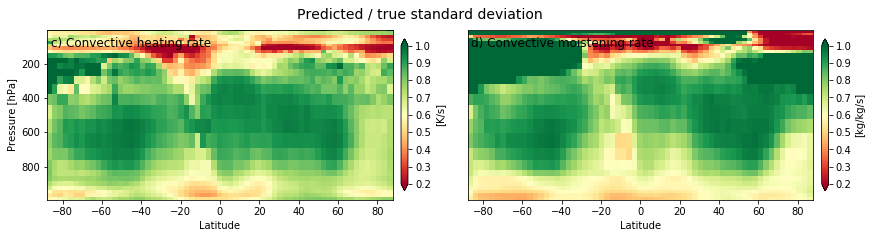

In [157]:
plot_4stats(d, '', 'Predicted / true standard deviation', vmult=0.3, cmap='RdYlGn', mylims=[0.2, 1],
            func=lambda d, v: (np.sqrt(d.stats['pred_var'][:,:,d.tvars.index(v)].mean(1)) /
                               np.sqrt(d.stats['true_var'][:,:,d.tvars.index(v)].mean(1))),
            rows=1, letter_offset=2
           )

#### R2 by lev

In [125]:
def r2_by_lev(d):
    #Avg the squared true values across lat, lon
    hor_sq = np.mean(d.stats['true_sqmean'], axis=(0,1))
    hor_mean = np.mean(d.stats['true_mean'], axis=(0,1))
    hor_mse = np.mean(d.stats['mse'], axis=(0,1))
    hor_var = hor_sq - hor_mean**2
    hor_r2 = 1 - (hor_mse / hor_var)
    return hor_r2

In [126]:
hor_r2 = r2_by_lev(d); hor_r2.shape

/export/home/srasp/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in true_divide
  import sys


(4, 30)

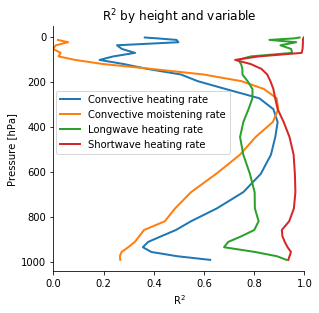

In [136]:
#sns.set_palette("hls", 4) 
fig, ax = plt.subplots(figsize=(4.5,4.5))
for i, v in enumerate(vars):
    ax.plot(hor_r2[i], lev, label=name[v], linewidth=2)
ax.invert_yaxis()
#ax.axhline(lev[10], c='gray', zorder=0.1)
ax.set_ylabel('Pressure [hPa]'); ax.set_xlabel(r'R$^2$')
ax.set_xlim(0, 1)
ax.set_title(r'R$^2$ by height and variable')
despine(ax)
ax.legend(loc=(0.01,0.48));

In [219]:
hor_r2[:, 10:].mean(1)

array([0.56886758, 0.51462891, 0.6844196 , 0.83636875])

In [232]:
d.mean_stats(10)

,bias,mse,pred_mean,true_mean,pred_sqmean,true_sqmean,pred_var,true_var,r2,hor_tsqmean,hor_tmean,hor_mse,hor_tvar,hor_r2
TPHYSTND_NORAD,-5.4342e-08,1.32802e-09,1.12797e-05,1.13341e-05,1.77112e-09,3.14639e-09,1.36493e-09,2.73519e-09,-0.25076,3.14639e-09,1.13341e-05,1.32802e-09,2.9559e-09,0.568868
PHQ,2.44682e-11,1.73768e-15,1.13412e-09,1.10965e-09,7.10566e-16,2.4729e-15,6.27573e-16,2.3929e-15,-25.0624,2.4729e-15,1.10965e-09,1.73768e-15,2.46201e-15,0.514629
QRL,7.25031e-09,1.64251e-10,-1.75578e-05,-1.75651e-05,6.8571e-10,8.64876e-10,2.57309e-10,4.30365e-10,0.377017,8.64876e-10,-1.75651e-05,1.64251e-10,4.90326e-10,0.68442
QRS,3.85513e-09,2.21544e-11,6.17175e-06,6.16789e-06,1.55168e-10,1.77935e-10,9.23633e-11,1.14664e-10,-inf,1.77935e-10,6.16789e-06,2.21544e-11,1.35396e-10,0.836369
all,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.651071
